In [32]:
pip install numpy pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# Import necessary python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb


In [34]:
# Read the data we have downloaded and look at what features we can use
spotify_tracks = pd.read_csv('spotify_dataset.csv')
spotify_tracks.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [35]:
# Further analyze the data to see the data types of each
spotify_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [36]:
# Find any null values in the data and where they are located
spotify_tracks.isnull().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [37]:
# We do not have many null values but we should remove them nevertheless
spotify_tracks.dropna(inplace= True)
#Check they are now gone
spotify_tracks.isnull().sum()

Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [38]:
# Drop columns we are not going to be using for our model
spotify_tracks = spotify_tracks.drop(labels='Unnamed: 0', axis= 1)
spotify_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          113999 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        113999 non-null  int64  
 5   duration_ms       113999 non-null  int64  
 6   explicit          113999 non-null  bool   
 7   danceability      113999 non-null  float64
 8   energy            113999 non-null  float64
 9   key               113999 non-null  int64  
 10  loudness          113999 non-null  float64
 11  mode              113999 non-null  int64  
 12  speechiness       113999 non-null  float64
 13  acousticness      113999 non-null  float64
 14  instrumentalness  113999 non-null  float64
 15  liveness          113999 non-null  float64
 16  valence           113999 

In [39]:
# Check for duplicate rows and drop them
duplicate_rows = spotify_tracks['track_id'].duplicated().sum()
if duplicate_rows != 0:
    # Drop rows dependent on duplicate track_id
    spotify_tracks = spotify_tracks.drop_duplicates(subset=['track_id'])

# Return amount of rows dropped
duplicate_rows

24259

In [41]:
num_data = spotify_tracks[spotify_tracks.columns[(spotify_tracks.dtypes == 'float64') | (spotify_tracks.dtypes == 'int64')]]
num_data.head()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4
1,55,149610,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4
2,57,210826,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4
3,71,201933,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3
4,82,198853,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4


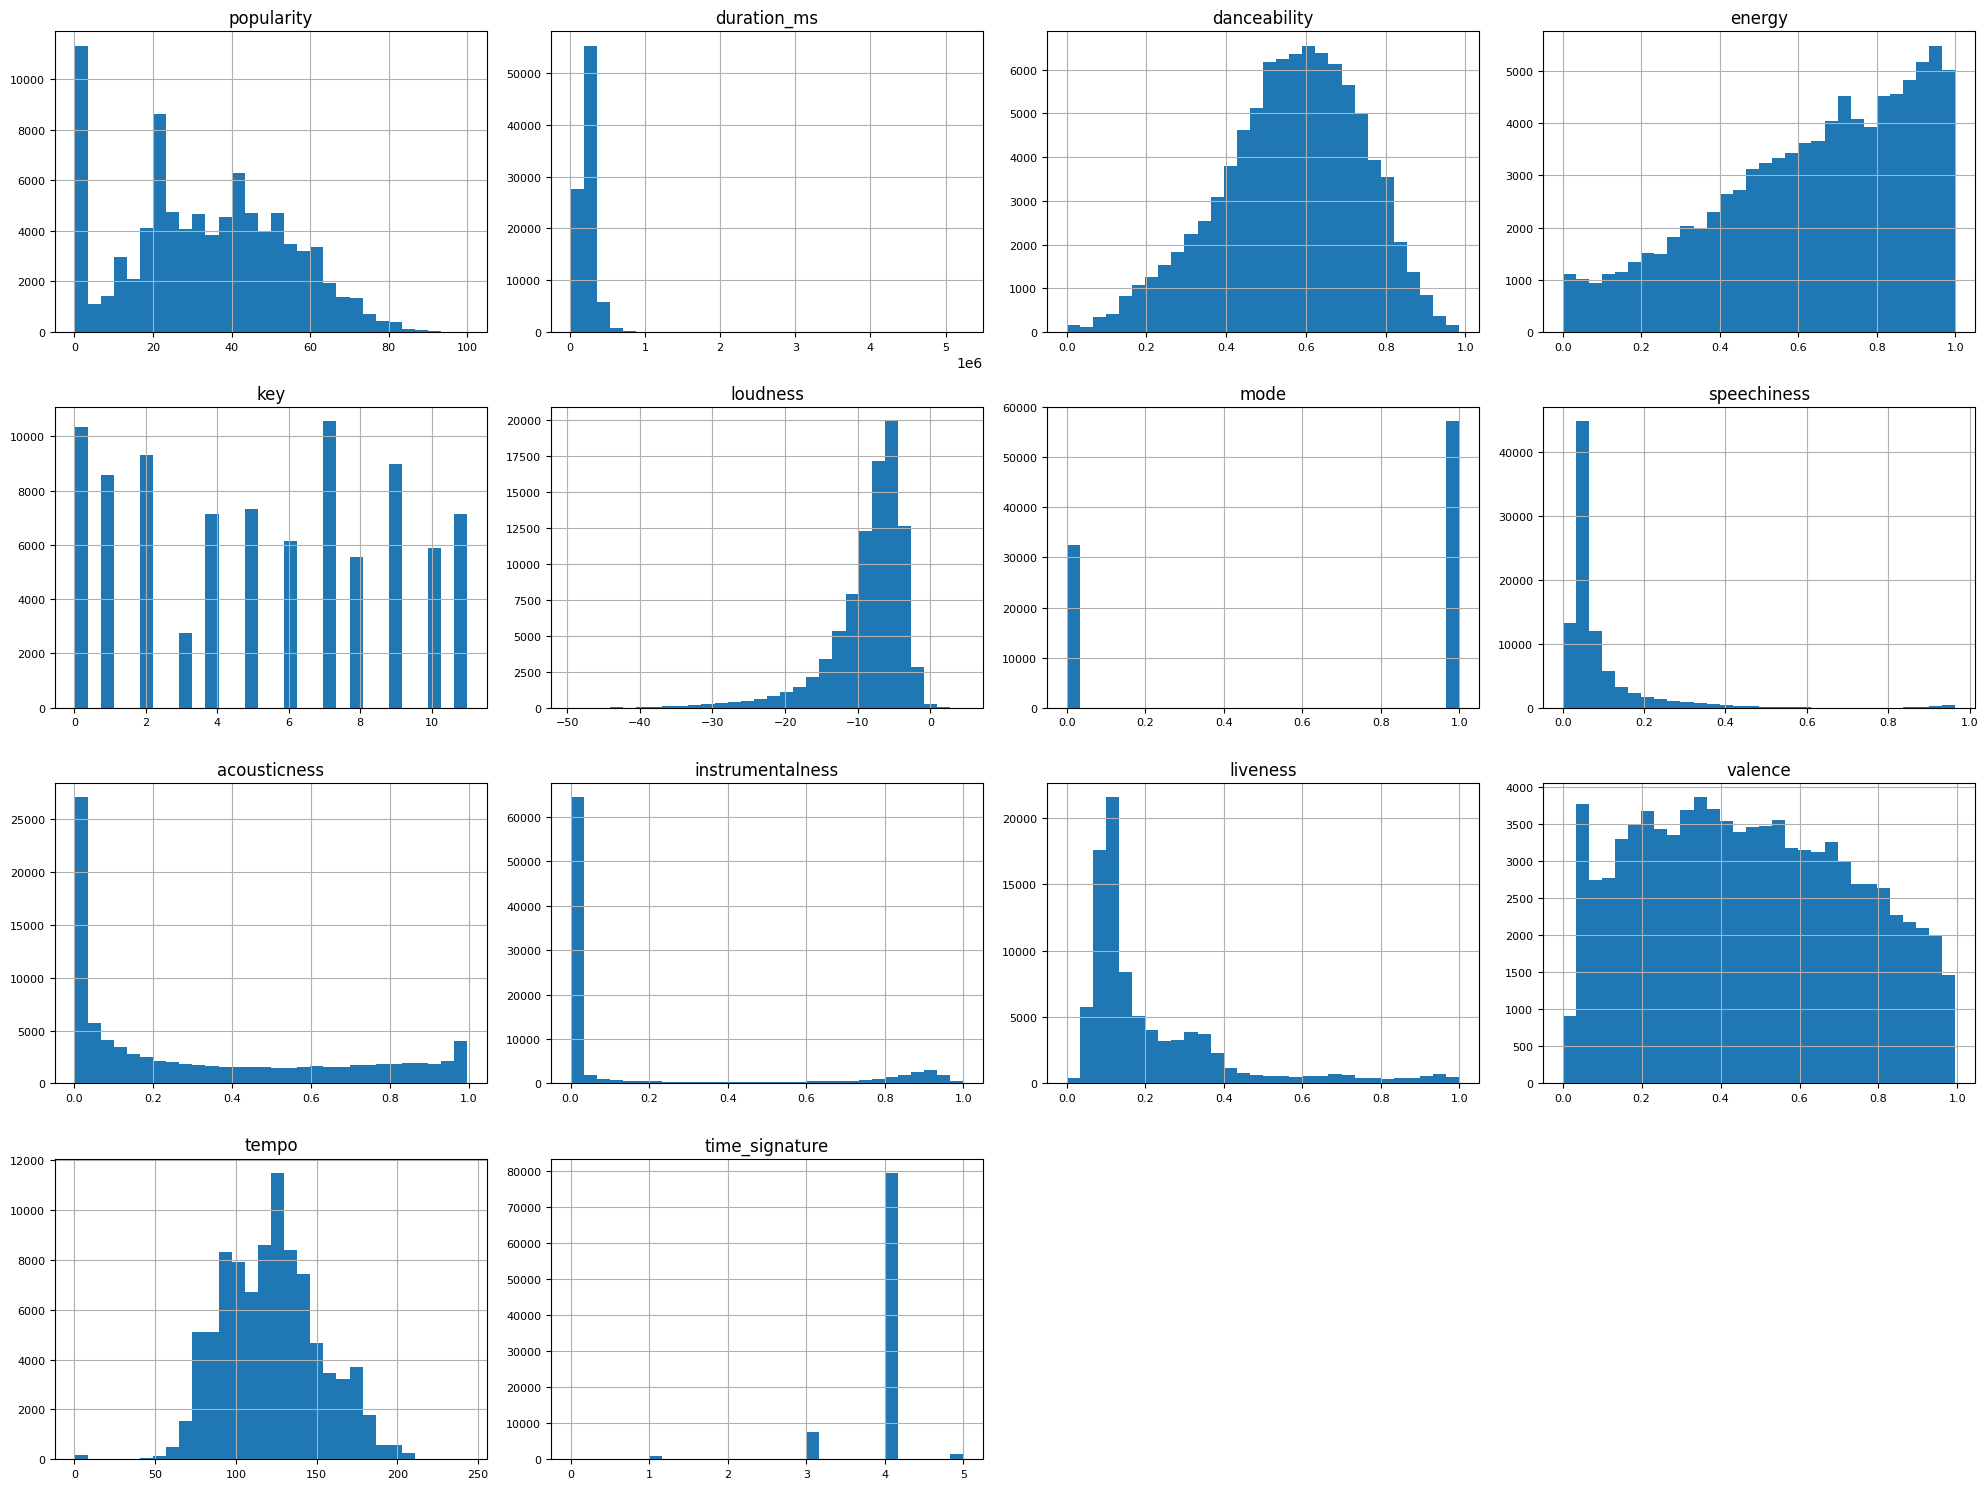

In [42]:
# Distribution of numerical data
num_data.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

In [44]:
# Delete outliers in duration and popularity to keep recommendations to songs that are not completely unknown and reasonable length
df = spotify_tracks[(spotify_tracks['duration_ms'] <= 600000) & (spotify_tracks['duration_ms'] >= 60000)]
df = df[df['popularity'] >= 10]
df.shape

(74778, 20)

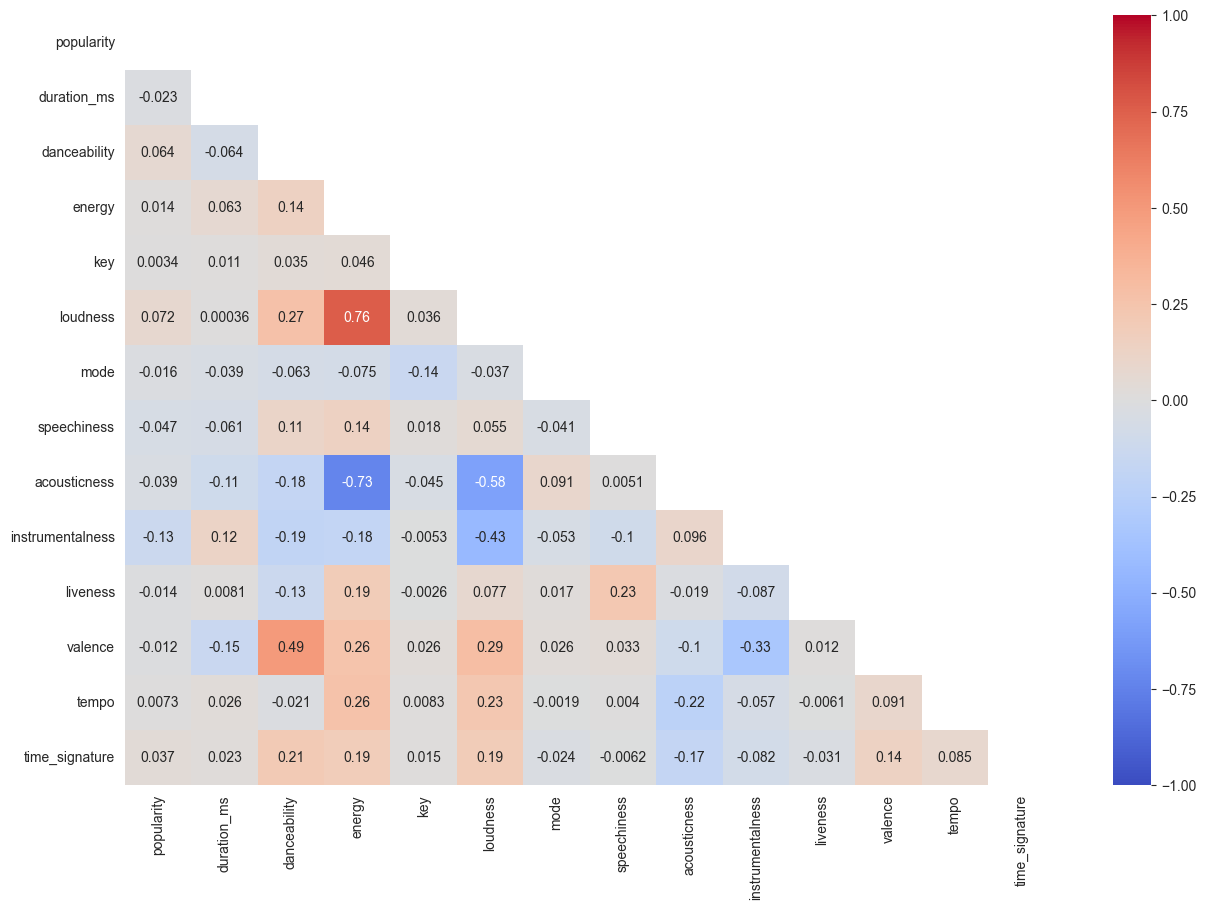

In [45]:
# Create a HeatMap to better identify the features that correlate the most or least with each other
corr = num_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sb.set_style('white')
plt.figure(figsize=(15, 10))
sb.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

In [46]:
# Remove/exclude time_signature and key due to their catagorical nature which encoding them could impact the results
df = df.drop(['time_signature','key'], axis=1)
df.shape

(74778, 18)